In [1]:
import keras
import tensorflow

Using TensorFlow backend.


In [2]:
#checking if gpu is visible
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tensorflow.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5328443417980283625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10240020819643639722
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'/device:GPU:0'

In [3]:
train_dir = r'datacd\train'
valid_dir = r'datacd\valid'
test_dir = r'datacd\test'

# Preprocessing

In [4]:
# actually the first step is to divide the data into two folders: cat, dog
# https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator

#augmentation of images for training
train_aug = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=15,
        horizontal_flip=True)

#augmentation for testing
valid_aug = ImageDataGenerator(rescale=1./255)

In [5]:
#tweak here
b_size = 200
inp_shape = 100

In [6]:
#loading train images
train_gen = train_aug.flow_from_directory(
        train_dir,
        target_size=(inp_shape, inp_shape),
        batch_size=b_size,
        class_mode='binary',
        color_mode='grayscale',
        classes=['cat','dog'])

#loading validation images
valid_gen = valid_aug.flow_from_directory(
        valid_dir,
        target_size=(inp_shape, inp_shape),
        batch_size=b_size,
        class_mode='binary',
        color_mode='grayscale',
        classes=['cat','dog'])

Found 22000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [56]:
#loading test images
test_gen = valid_aug.flow_from_directory(
        test_dir,
        target_size=(inp_shape, inp_shape),
        batch_size=b_size,
        class_mode=None,
        color_mode='grayscale',
        shuffle=False)

Found 12500 images belonging to 1 classes.


# Model

In [8]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization

In [9]:
model = Sequential()

model.add(Conv2D(32,3,3, input_shape=(inp_shape, inp_shape, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,3,3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,3,3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,3,3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

C:\Users\Liyonn\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(100, 100,...)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Liyonn\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if __name__ == '__main__':
C:\Users\Liyonn\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  from ipykernel import kernelapp as app
C:\Users\Liyonn\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3))`


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 64)       

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

stop_early = EarlyStopping(patience=10)
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=2,
                        verbose=1,
                        factor=0.5,
                        min_lr=0.00001)

In [13]:
history = model.fit_generator(
        train_gen,
        steps_per_epoch=22000 // b_size,
        epochs=50,
        validation_data=valid_gen,
        validation_steps=3000 // b_size,
        callbacks=[stop_early, lrr])

Epoch 1/50
110/110 [==============================] - 61s 555ms/step - loss: 0.9132 - accuracy: 0.5382 - val_loss: 0.7529 - val_accuracy: 0.5010
Epoch 2/50
110/110 [==============================] - 48s 432ms/step - loss: 0.6852 - accuracy: 0.5824 - val_loss: 0.6852 - val_accuracy: 0.6047
Epoch 3/50
110/110 [==============================] - 47s 432ms/step - loss: 0.6507 - accuracy: 0.6342 - val_loss: 0.9207 - val_accuracy: 0.5063
Epoch 4/50
110/110 [==============================] - 47s 428ms/step - loss: 0.5917 - accuracy: 0.6904 - val_loss: 0.5969 - val_accuracy: 0.6697
Epoch 5/50
110/110 [==============================] - 47s 428ms/step - loss: 0.5335 - accuracy: 0.7371 - val_loss: 0.6073 - val_accuracy: 0.6887
Epoch 6/50
110/110 [==============================] - 49s 443ms/step - loss: 0.4929 - accuracy: 0.7635 - val_loss: 1.0979 - val_accuracy: 0.5640
Epoch 7/50
110/110 [==============================] - 46s 422ms/step - loss: 0.4572 - accuracy: 0.7856 - val_loss: 0.4876 - val_ac

In [14]:
model.save('catdogmodel.h5')

# Plots

In [15]:
import matplotlib.pyplot as plt
import numpy as np

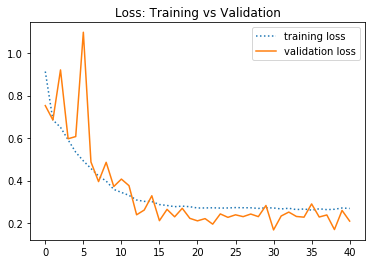

In [16]:
plt.plot(history.history['loss'], label='training loss', linestyle=':')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss: Training vs Validation')
plt.legend()
plt.show()

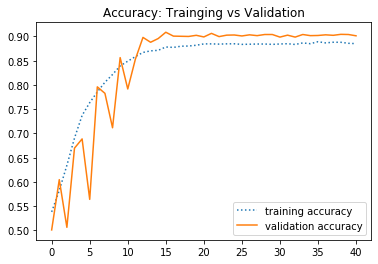

In [17]:
plt.plot(history.history['accuracy'], label='training accuracy', linestyle=':')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy: Trainging vs Validation')
plt.legend()
plt.show()

In [18]:
print('train data accuracy:')
print(model.evaluate(train_gen))

train data accuracy:
110/110 [==============================] - 52s 472ms/step
[0.2756619155406952, 0.8997272849082947]


In [58]:
preds = model.predict_generator(test_gen)

In [59]:
preds

array([[9.3714672e-01],
       [8.7320805e-06],
       [1.5533152e-01],
       ...,
       [8.5379690e-01],
       [8.5592270e-05],
       [6.1619073e-02]], dtype=float32)

In [60]:
preds.shape

(12500, 1)

In [64]:
preds[0][0]

0.9371467

In [43]:
from keras.preprocessing.image import load_img, image
import os

In [44]:
img_dir = r'C:\Users\Liyonn\Desktop\project_dogvscat\datacd\test\test'
images = os.listdir(img_dir)
images[:3]

['1.jpg', '10.jpg', '100.jpg']

In [45]:
full_images = [os.path.join(img_dir, img) for img in images]

In [ ]:
len(full_images)

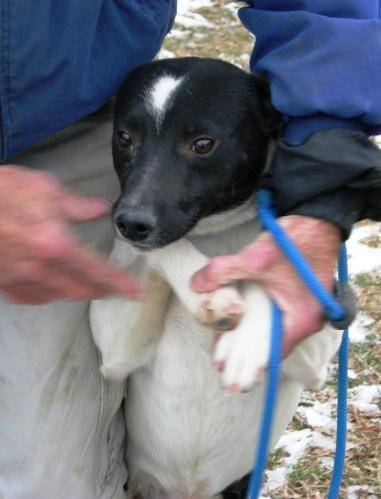

In [47]:
image_index = 0
load_img(full_images[image_index])

In [ ]:
check_idx = 13
plt.imshow(test_sample[check_idx] / 255)


text = 'The network is: {:.2f}% sure it is a dog,\nbut really it is a {}, so the network {}'
correct_response = true_labels[check_idx]
it_is_really = ['cat', 'dog'][correct_response]
net_claims = predictions[check_idx, 0]
is_net_correct = np.abs(net_claims - correct_response) < 0.5

plt.title(text.format(net_claims * 100., it_is_really, ['is wrong', 'is right'][is_net_correct]))
plt.axis('off')

In [ ]:
imgnum = input("input your photo number here:\n")

In [ ]:
print("This is the prediction for that photo:\n")
print(preds[imgnum][0])
print("And this is the photo:\n") # maybe
load_img(full_images[imgnum])